## Setup & Data Loading

In [15]:
print("Installing required packages...")
%pip install yfinance > /dev/null 2>&1
%pip install torch torchvision torchaudio > /dev/null 2>&1
%pip install python-dotenv > /dev/null 2>&1
%pip install seaborn > /dev/null 2>&1
print("All packages installed.")

Installing required packages...
Note: you may need to restart the kernel to use updated packages.
Note: you may need to restart the kernel to use updated packages.
Note: you may need to restart the kernel to use updated packages.
Note: you may need to restart the kernel to use updated packages.
All packages installed.


In [16]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from dotenv import load_dotenv
import os
import requests
import time
import seaborn as sns

# scikit-learn
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA, KernelPCA
from sklearn.ensemble import IsolationForest
from sklearn.cluster import KMeans
from sklearn.linear_model import LinearRegression
from sklearn.metrics import r2_score
from sklearn.metrics import mean_squared_error


# PyTorch
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, TensorDataset
 
import yfinance as yf

## Datasets + Preprocessing

### 1: S&P500 - Yahoo Finance

In [17]:
# s&p500 and individual tech stocks
symbols = [
    '^GSPC',
    'META',
    'AMZN',
    'AAPL',
    'NFLX',
    'GOOG',
    'MSFT',
    'NVDA',
    'TSLA'
]
# 13 year range
start_date = "2012-01-01"
end_date = "2025-04-09"

In [18]:
data = yf.download(symbols, start=start_date, end=end_date, auto_adjust=True)
data.head()

[*********************100%***********************]  9 of 9 completed


Price           Close                                                          \
Ticker           AAPL    AMZN       GOOG META       MSFT       NFLX      NVDA   
Date                                                                            
2012-01-03  12.375391  8.9515  16.495001  NaN  21.077822  10.320000  0.321867   
2012-01-04  12.441899  8.8755  16.566147  NaN  21.573877  11.492857  0.325535   
2012-01-05  12.580024  8.8805  16.336349  NaN  21.794340  11.328571  0.337227   
2012-01-06  12.711536  9.1305  16.113497  NaN  22.132906  12.327143  0.333330   
2012-01-09  12.691375  8.9280  15.430305  NaN  21.841581  14.025714  0.333330   

Price                                   High  ...         Open     Volume  \
Ticker          TSLA        ^GSPC       AAPL  ...        ^GSPC       AAPL   
Date                                          ...                           
2012-01-03  1.872000  1277.060059  12.413610  ...  1258.859985  302220800   
2012-01-04  1.847333  1277.300049  12.479216  ...  1277.030029  260022000   
2012-01-05  1.808000  1281.060059  12.595672  ...  1277.300049  271269600   
2012-01-06  1.794000  1277.810059  12.722069  ...  1280.930054  318292800   
2012-01-09  1.816667  1280.699951  12.872538  ...  1277.829956  394024400   

Price                                                                  \
Ticker           AMZN       GOOG META      MSFT       NFLX       NVDA   
Date                                                                    
2012-01-03  102216000  147611217  NaN  64731500   29213800  468044000   
2012-01-04   84104000  114989399  NaN  80516100  100489900  347372000   
2012-01-05   76182000  131808205  NaN  56081400   86552900  563548000   
2012-01-06  140168000  108119746  NaN  99455500  125610800  533252000   
2012-01-09  101138000  233776981  NaN  59706800  214073300  508244000   

Price                             
Ticker          TSLA       ^GSPC  
Date                              
2012-01-03  13921500  3943710000  
2012-01-04   9451500  3592580000  
2012-01-05  15082500  4315950000  
2012-01-06  14794500  3656830000  
2012-01-09  13455000  3371600000  

[5 rows x 45 columns]

In [19]:
portfolio_returns = np.log(data['Close'] / data['Close'].shift(1)).dropna()
portfolio_returns

Ticker,AAPL,AMZN,GOOG,META,MSFT,NFLX,NVDA,TSLA,^GSPC
Date,,,,,,,,,
2012-05-21,0.056626,0.019725,0.022578,-0.116378,0.016266,0.025125,0.017235,0.042968,0.015909
2012-05-22,-0.007709,-0.012828,-0.021912,-0.093255,0.000336,-0.057815,-0.012281,0.068181,0.000486
2012-05-23,0.024107,0.009015,0.014311,0.031749,-0.022083,0.060181,0.024412,0.007118,0.001692
2012-05-24,-0.009226,-0.009433,-0.009562,0.031680,-0.001375,-0.023070,-0.026885,-0.024145,0.001379
2012-05-25,-0.005375,-0.010978,-0.020299,-0.034497,-0.000344,-0.000712,0.023665,-0.015644,-0.002168
...,...,...,...,...,...,...,...,...,...
2025-04-02,0.003131,0.019785,-0.000126,-0.003539,-0.000131,0.007661,0.002448,0.051897,0.006706
2025-04-03,-0.097013,-0.094081,-0.040007,-0.093852,-0.023914,-0.019941,-0.081281,-0.056302,-0.049606
2025-04-04,-0.075680,-0.042421,-0.032563,-0.051905,-0.036214,-0.069055,-0.076423,-0.110036,-0.061609


### 2: Alpha Vantage API
[Alpha Vantage API Documentation](https://www.alphavantage.co/documentation/#dailyadj)

In [20]:
load_dotenv()
function = "TIME_SERIES_DAILY"
api_key = os.getenv("ALPHA_VANTAGE_API_KEY")
symbol = "META"

In [21]:
response = requests.get(
    f"https://www.alphavantage.co/query?function={function}&symbol={symbol}&outputsize=full&apikey={api_key}"
)
json_data = response.json()

num_rows = len(json_data["Time Series (Daily)"])
print(f"There are {num_rows} days in this JSON object")

There are 3248 days in this JSON object


In [22]:
def parse(json_data):
    ts_key = "Time Series (Daily)"
    
    if "Error Message" in json_data:
        raise ValueError(f"Alpha Vantage API error: {json_data['Error Message']}")
    if "Note" in json_data:
        raise ValueError(f"Rate limit notice: {json_data['Note']}")
    if ts_key not in json_data:
        raise ValueError("Expected 'Time Series (Daily)' in response.")

    # Extract the raw time series data
    raw_data = json_data[ts_key]

    # Create DataFrame
    df = pd.DataFrame.from_dict(raw_data, orient="index")

    # Rename columns
    df.rename(columns={
        "1. open": "open",
        "2. high": "high",
        "3. low": "low",
        "4. close": "close",
        "5. volume": "volume"
    }, inplace=True)

    # Convert index to datetime and sort
    df.index = pd.to_datetime(df.index)
    df = df.sort_index()

    # Convert column types
    df = df.astype({
        "open": float,
        "high": float,
        "low": float,
        "close": float,
        "volume": int
    })

    return df

In [30]:
df_vantage = parse(json_data)
df_vantage

,open,high,low,close,volume
2012-05-18,42.050,45.00,38.0000,38.2318,573576400
2012-05-21,36.530,36.66,33.0000,34.0300,168192700
2012-05-22,32.610,33.59,30.9400,31.0000,101786600
2012-05-23,31.370,32.50,31.3600,32.0000,73600000
2012-05-24,32.950,33.21,31.7700,33.0300,50237200
...,...,...,...,...,...
2025-04-11,535.505,547.40,528.5901,543.5700,17642327
2025-04-14,556.175,557.77,528.2800,531.4800,14130928
2025-04-15,532.105,537.94,517.5000,521.5200,15558659
2025-04-16,508.510,513.37,495.6300,502.3100,18735075


In [31]:
vantage_returns = np.log(df_vantage["close"] / df_vantage["close"].shift(1)).dropna()
vantage_returns

2012-05-21   -0.116425
2012-05-22   -0.093255
2012-05-23    0.031749
2012-05-24    0.031680
2012-05-25   -0.034497
                ...   
2025-04-11   -0.004991
2025-04-14   -0.022493
2025-04-15   -0.018918
2025-04-16   -0.037530
2025-04-17   -0.001654
Name: close, Length: 3247, dtype: float64

### 3: WRDS Factors (Backtester) Plus by WRDS

In [36]:
# convert percentage strings to floats
def convert_percent(col):
    return pd.to_numeric(col.astype(str).str.replace('%', '', regex=False), errors='coerce') / 100

In [39]:
df_factors = pd.read_csv('../data/wrds_factors.csv')

# Convert all percentage columns (assuming they all except the first two are %)
for col in df_factors.columns[2:]:
    df_factors[col] = convert_percent(df_factors[col])

# Preview
df_factors.head()

,Date,fdate,beta_AR_1,beta_AR_2,beta_AR_3,beta_AR_4,beta_AR_5,beta_TR_1,beta_TR_2,beta_TR_3,...,beta_CAR_LS,beta_CTR_LS,beta_CAR_SW,beta_CTR_SW,beta_CTR_BP,beta_CTR_LO,beta_CXR_LO,beta_CTR_13,beta_CADD,beta_CTDD
0,2000-02-29,2000-01-31,-0.0501,-0.0536,-0.0254,-0.0325,-0.0202,0.2245,0.0738,0.0875,...,0.0299,-0.0547,0.0310,-0.0740,0.0238,0.1599,0.1360,0.1377,0.0000,-0.0740
1,2000-03-31,2000-02-29,0.1529,0.0711,0.0340,0.0178,0.0782,-0.0140,0.0364,0.0145,...,-0.0471,-0.0410,-0.0595,-0.0484,0.0940,0.1636,0.0618,0.1507,-0.0877,-0.0484
2,2000-04-30,2000-03-31,0.0056,0.0018,-0.0049,-0.0082,-0.0543,-0.1318,-0.0433,-0.1000,...,-0.1042,-0.0203,-0.1109,-0.0193,0.0352,0.0422,0.0081,0.0413,-0.1376,-0.0193
3,2000-05-31,2000-04-30,-0.0051,-0.0043,-0.0015,-0.0007,-0.0101,-0.1272,-0.0399,-0.0497,...,-0.1086,0.0524,-0.1149,0.0604,-0.0016,-0.0084,-0.0049,0.0161,-0.1414,0.0000
4,2000-06-30,2000-05-31,-0.0581,-0.0049,0.0076,-0.0008,-0.0219,0.1659,0.0470,0.0724,...,-0.0764,-0.0640,-0.0846,-0.0736,0.0437,0.0379,-0.0037,0.0250,-0.1121,-0.1263


## Exploratory Analysis

In [ ]:
# Set up default seaborn style
sns.set_theme(style="whitegrid")

# === Summary Statistics ===
print("Portfolio Summary Statistics:")
print(portfolio_returns.describe())

print("\nVantage META Summary Statistics:")
print(vantage_returns.describe())

print("\nWRDS Factors Summary Statistics:")
print(vantage_returns.describe())

Portfolio Summary Statistics:
Ticker         AAPL         AMZN         GOOG         META         MSFT  \
count   3240.000000  3240.000000  3240.000000  3240.000000  3240.000000   
mean       0.000735     0.000855     0.000706     0.000801     0.000840   
std        0.017822     0.020178     0.017184     0.025108     0.016467   
min       -0.137708    -0.151398    -0.117667    -0.306391    -0.159453   
25%       -0.007523    -0.008836    -0.007115    -0.010064    -0.006853   
50%        0.000899     0.000891     0.000846     0.001040     0.000731   
75%        0.010177     0.011553     0.009257     0.012721     0.009365   
max        0.113158     0.132178     0.148872     0.259371     0.132929   

Ticker         NFLX         NVDA         TSLA        ^GSPC  
count   3240.000000  3240.000000  3240.000000  3240.000000  
mean       0.001379     0.001806     0.001480     0.000416  
std        0.029519     0.028464     0.036047     0.010669  
min       -0.432578    -0.207712    -0.236518    -

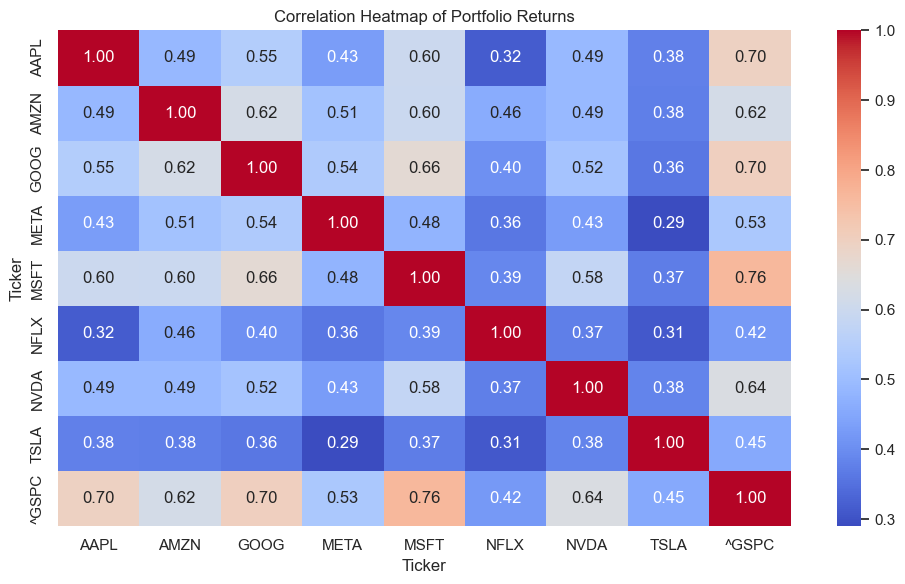

In [27]:
# === Correlation Matrix ===
plt.figure(figsize=(10, 6))
sns.heatmap(portfolio_returns.corr(), annot=True, fmt=".2f", cmap="coolwarm")
plt.title("Correlation Heatmap of Portfolio Returns")
plt.tight_layout()
plt.show()

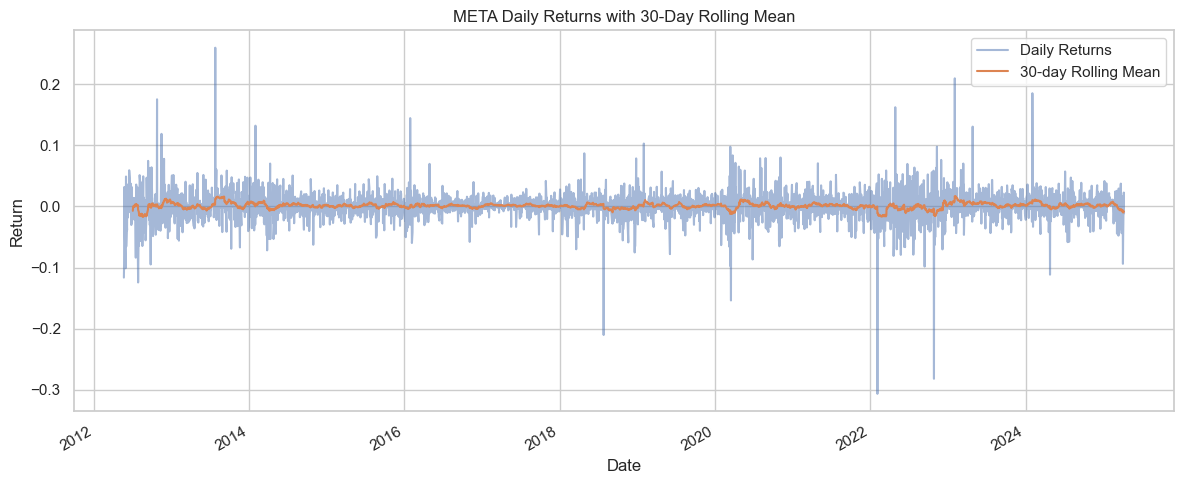

In [28]:
# === Time Series of META Returns (Yahoo) ===
plt.figure(figsize=(12, 5))
portfolio_returns["META"].plot(label="Daily Returns", alpha=0.5)
portfolio_returns["META"].rolling(window=30).mean().plot(label="30-day Rolling Mean")
plt.title("META Daily Returns with 30-Day Rolling Mean")
plt.xlabel("Date")
plt.ylabel("Return")
plt.legend()
plt.tight_layout()
plt.show()

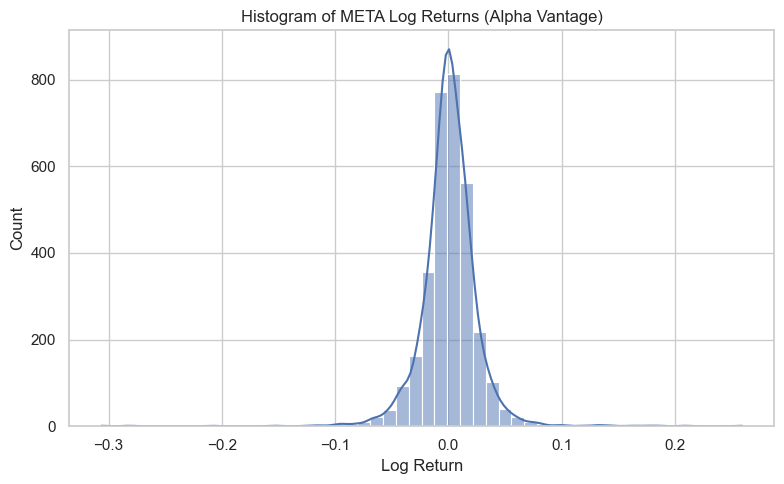

In [29]:
# === Histogram of META Returns from Alpha Vantage ===
plt.figure(figsize=(8, 5))
sns.histplot(vantage_returns, bins=50, kde=True)
plt.title("Histogram of META Log Returns (Alpha Vantage)")
plt.xlabel("Log Return")
plt.tight_layout()
plt.show()

## Outlier Detection

In [ ]:
# traditional methods
def detect_outliers_iqr(data, threshold=1.5):
  q1 = np.percentile(data, 25)
  q3 = np.percentile(data, 75)
  iqr = q3 - q1
  return (data < q1 - threshold*iqr) | (data > q3 + threshold*iqr)

In [ ]:
outliers_traditional = detect_outliers_iqr(returns_scaled)

In [ ]:
# ML-based (Isolation Forest)
iso_forest = IsolationForest(contamination=0.05, random_state=42)
outliers = iso_forest.fit_predict(returns_scaled)

In [ ]:
# Comparing results
print(f"Traditional IQR outliers: {np.sum(outliers_traditional)}")
print(f"Isolation Forest outliers: {np.sum(outliers == -1)}")

## Uncovering Latent Structures: PCA vs Nonlinear PCA (Autoencoder)

### Traditional PCA

In [15]:
# Traditional PCA Analysis
X_scaled = StandardScaler().fit_transform(portfolio_returns)

# Fit PCA
pca = PCA(n_components=3)
pca_factors = pca.fit_transform(X_scaled)
pca_returns_df = pd.DataFrame(pca_factors, index=portfolio_returns.index, columns=["f1", "f2", "f3"])

In [16]:
pca_exposures_df = pd.DataFrame(index=portfolio_returns.columns, columns=["f1", "f2", "f3"]).astype(float)

for asset in portfolio_returns.columns:
    lr = LinearRegression()
    lr.fit(pca_returns_df, portfolio_returns[asset].values)
    pca_exposures_df.loc[asset] = lr.coef_

In [17]:
# returns a vector of explained variance by each component
pct = pca.explained_variance_ratio_

# get the influence each component has on the features
pca_components = pca.components_

(0.0, 100.0)

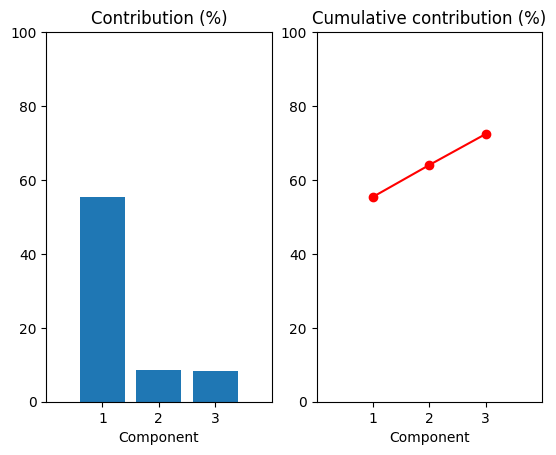

In [18]:
# plotting
cum_pct = np.cumsum(pct)
x = np.arange(1, len(pct)+1, 1)

plt.subplot(1, 2, 1)
plt.bar(x, pct * 100, align="center")
plt.title("Contribution (%)")
plt.xlabel('Component')
plt.xticks(x)
plt.xlim([0, 4])
plt.ylim([0, 100])

plt.subplot(1, 2, 2)
plt.plot(x, cum_pct * 100, 'ro-')
plt.title('Cumulative contribution (%)')
plt.xlabel('Component')
plt.xticks(x)
plt.xlim([0, 4])
plt.ylim([0, 100])

In [19]:
# multiply returns by components and transpose the dataframe
X = np.asarray(portfolio_returns)

factor_returns = X.dot(pca_components.T)

# recall that we set n_components=3 earlier to denote how many principal components we want
factor_returns = pd.DataFrame(
    columns=["f1", "f2", "f3"],
    index=portfolio_returns.index,
    data=factor_returns
)

factor_returns.head()

,f1,f2,f3
Date,,,
2012-05-21,0.034164,0.016855,0.077611
2012-05-22,-0.045159,-0.000969,0.111989
2012-05-23,0.044159,0.041568,-0.025642
2012-05-24,-0.021176,-0.024789,-0.023859
2012-05-25,-0.020887,-0.004525,0.010102


In [20]:
# plot the portfolio returns influenced by the first factor
factor_exposures = pd.DataFrame(
    index=["f1", "f2", "f3"],
    columns=portfolio_returns.columns,
    data = pca_components
).T

factor_exposures

,f1,f2,f3
Ticker,,,
AAPL,0.336531,-0.299889,0.223876
AMZN,0.349491,0.099143,-0.228253
GOOG,0.365492,-0.151455,-0.155372
META,0.305070,-0.031314,-0.398382
MSFT,0.372970,-0.237662,0.016927
NFLX,0.260592,0.733540,-0.376194
NVDA,0.330440,-0.062036,0.142906
TSLA,0.251986,0.492389,0.735977
^GSPC,0.397804,-0.188305,0.105064


Text(0.5, 1.0, 'Asset Loadings on Principal Component 1')

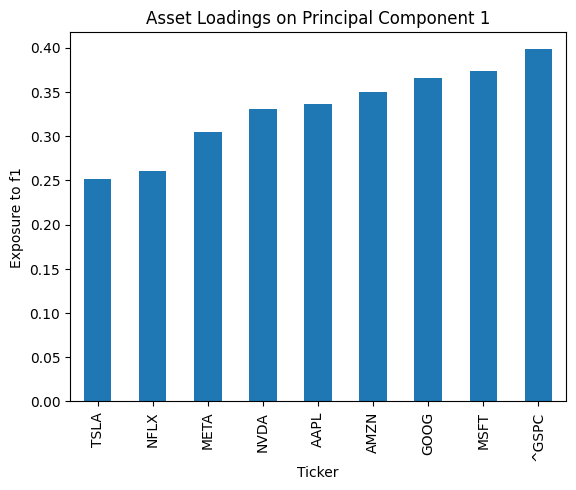

In [21]:
factor_exposures.f1.sort_values().plot.bar()
plt.ylabel("Exposure to f1")
plt.title("Asset Loadings on Principal Component 1")

The bar chart plots the loadings (or exposures) of the first principal component (f1) across all the assets in the portfolio (including ^GSPC, AAPL, MSFT, etc.).

These values represent how much each asset contributes to the first principal component, which typically captures the largest source of variance in the dataset.

Analysis:
* TSLA, NVDA, and NFLX have high positive exposures to the first principal component, suggesting they are strongly aligned with the main factor driving portfolio variance.

* ^GSPC (S&P 500) has the lowest exposure, meaning its behavior is less influenced by this main factor compared to the others.

* This makes sense—^GSPC is a broad market index, often more diversified and stable.

* Stocks like AAPL, MSFT, GOOG are in the middle — they move with the first factor, but not as strongly as TSLA or NVDA.

* Given that tech/growth stocks (like TSLA, NVDA) dominate the top end, `f1` could be interpreted as a “growth/tech risk factor”.

Text(0.5, 1.0, 'Asset Loadings on Principal Component 2')

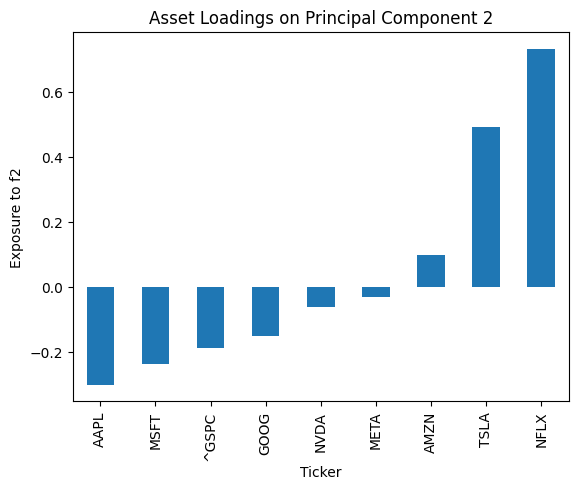

In [22]:
factor_exposures.f2.sort_values().plot.bar()
plt.ylabel("Exposure to f2")
plt.title("Asset Loadings on Principal Component 2")

TSLA loads heavily positive on f2, and several other tech stocks like NFLX, META, NVDA load negatively, while the rest (including the index) are near neutral.

`f2` might capture a unique risk or return profile specific to TSLA, such as:
* Idiosyncratic volatility or momentum (TSLA often behaves very differently from even other tech stocks) - most likely due to recent political events
* A "speculative growth" factor (TSLA being the face of that in recent years)

Text(0.5, 1.0, 'Asset Loadings on Principal Component 3')

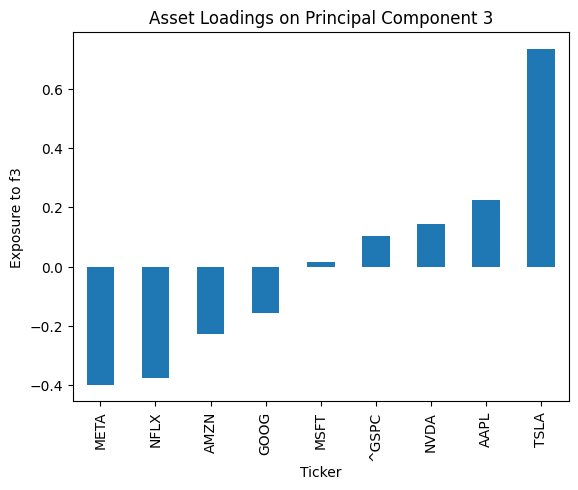

In [23]:
factor_exposures.f3.sort_values().plot.bar()
plt.ylabel("Exposure to f3")
plt.title("Asset Loadings on Principal Component 3")

From the plot:
* NFLX has a very strong positive exposure to f3 (~0.85+)
* NVDA has a strong negative exposure (~-0.4)
* META, AAPL, MSFT, GOOG, etc. have mild to moderate negative exposures
* TSLA and AMZN are slightly positive

This kind of distribution suggests that f3 might represent a volatility or risk sentiment factor — for example:
* High positive exposure (NFLX): Might reflect a unique return pattern or idiosyncratic risk (e.g., high beta, high growth, high volatility).
* High negative exposure (NVDA, META): Suggests an opposite movement — perhaps NVDA's price movements diverge from those of NFLX in this principal component's dimension.
* Other large-cap stocks are close to neutral or slightly negative.



### Autoencoder

We will define our model in the following ways:
* Architecture: Encoder: input -> 64 neurons -> latent; Decoder: latent -> 64 neurons -> input
* Objective: MSE loss during training
* Latent Representation: `latent = self.encoder(x)` -> 3D representation
* Optimization: Adam optimizer used in training loop

In [24]:
# Defining Autoencoder (PyTorch)
class Autoencoder(nn.Module):
  def __init__(self, input_dim, latent_dim):
    super().__init__()
    self.encoder = nn.Sequential(
        nn.Linear(input_dim, 128),
        nn.ReLU(),
        nn.Linear(128, latent_dim)
    )
    self.decoder = nn.Sequential(
        nn.Linear(latent_dim, 128),
        nn.ReLU(),
        nn.Linear(128, input_dim)
    )

  def forward(self, x):
    latent = self.encoder(x)
    reconstructed = self.decoder(latent)
    return reconstructed, latent

In [25]:
# Standardize the returns data
scaler = StandardScaler()
X_scaled = scaler.fit_transform(portfolio_returns)
X_tensor = torch.tensor(X_scaled, dtype=torch.float32)

In [26]:
input_dim = X_tensor.shape[1]  # e.g., 10 stocks
latent_dim = 3                 # same as n_components in PCA

model = Autoencoder(input_dim, latent_dim)

In [27]:
# training
optimizer = optim.Adam(model.parameters(), lr=0.01)
loss_fn = nn.MSELoss()

for epoch in range(1000):
    model.train()
    optimizer.zero_grad()
    recon, z = model(X_tensor)
    loss = loss_fn(recon, X_tensor)
    loss.backward()
    optimizer.step()
    if epoch % 100 == 0:
        print(f"Epoch {epoch}, Loss: {loss.item():.4f}")

Epoch 0, Loss: 1.0180
Epoch 100, Loss: 0.2469
Epoch 200, Loss: 0.2110
Epoch 300, Loss: 0.1946
Epoch 400, Loss: 0.1892
Epoch 500, Loss: 0.1820
Epoch 600, Loss: 0.1770
Epoch 700, Loss: 0.1735
Epoch 800, Loss: 0.1730
Epoch 900, Loss: 0.1693


In [28]:
# Extract latent features
with torch.no_grad():
    _, factor_returns = model(X_tensor)

factor_returns_df = pd.DataFrame(
    factor_returns.numpy(),
    index=portfolio_returns.index,
    columns=["f1", "f2", "f3"]
)

factor_exposures_df = factor_exposures_df = pd.DataFrame(index=portfolio_returns.columns, columns=["f1", "f2", "f3"]).astype(float)

for asset in portfolio_returns.columns:
    lr = LinearRegression()
    lr.fit(factor_returns_df, portfolio_returns[asset].values)
    factor_exposures_df.loc[asset] = lr.coef_

factor_exposures_df

,f1,f2,f3
Ticker,,,
AAPL,0.000721,-0.002618,0.006777
AMZN,-0.001439,-0.005601,0.005329
GOOG,0.000139,-0.004233,0.005945
META,-0.003701,-0.000671,0.008541
MSFT,0.000656,-0.004198,0.005922
NFLX,-0.008473,-0.008998,0.000992
NVDA,0.001894,-0.007817,0.008779
TSLA,-0.007238,-0.005207,0.005333
^GSPC,0.000085,-0.002538,0.004148


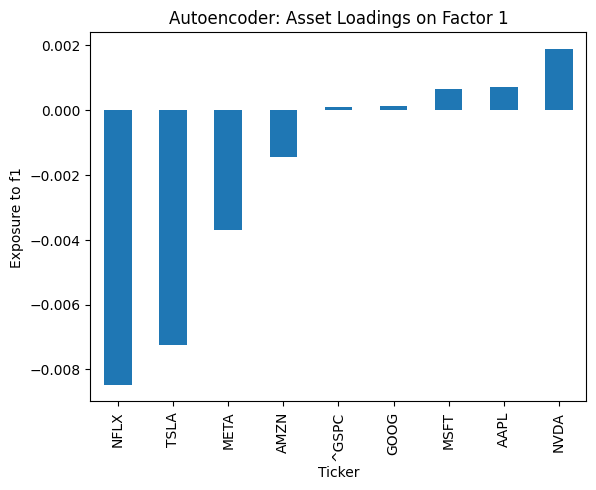

In [29]:
factor_exposures_df["f1"].sort_values().plot(kind='bar')
plt.ylabel("Exposure to f1")
plt.title("Autoencoder: Asset Loadings on Factor 1")
plt.show()

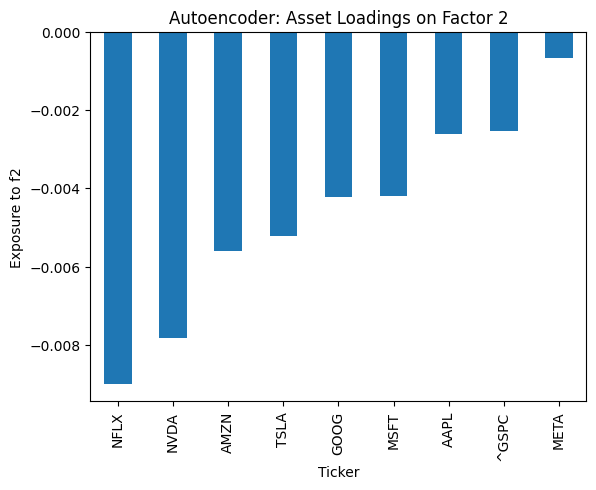

In [30]:
factor_exposures_df["f2"].sort_values().plot(kind='bar')
plt.ylabel("Exposure to f2")
plt.title("Autoencoder: Asset Loadings on Factor 2")
plt.show()

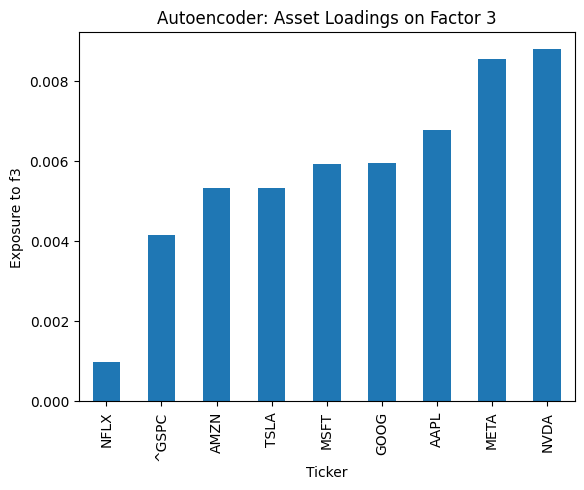

In [31]:
factor_exposures_df["f3"].sort_values().plot(kind='bar')
plt.ylabel("Exposure to f3")
plt.title("Autoencoder: Asset Loadings on Factor 3")
plt.show()

### Comparing Metrics

In [32]:
results = []

for asset in portfolio_returns.columns:
    y_true = portfolio_returns[asset].values

    # Autoencoder prediction
    y_pred_ae = factor_returns_df.values @ factor_exposures_df.loc[asset].values
    r2_ae = r2_score(y_true, y_pred_ae)
    mse_ae = mean_squared_error(y_true, y_pred_ae)

    # PCA prediction
    y_pred_pca = pca_returns_df.values @ pca_exposures_df.loc[asset].values
    r2_pca = r2_score(y_true, y_pred_pca)
    mse_pca = mean_squared_error(y_true, y_pred_pca)

    results.append({
        "Ticker": asset,
        "R2_Autoencoder": r2_ae,
        "R2_PCA": r2_pca,
        "MSE_Autoencoder": mse_ae,
        "MSE_PCA": mse_pca
    })

comparison_df = pd.DataFrame(results).set_index("Ticker")

In [33]:
print(comparison_df.sort_values("R2_Autoencoder", ascending=False))

        R2_Autoencoder    R2_PCA  MSE_Autoencoder   MSE_PCA
Ticker                                                     
^GSPC         0.784113  0.823855         0.000025  0.000020
NFLX          0.712633  0.860969         0.000250  0.000121
MSFT          0.705769  0.735480         0.000080  0.000072
GOOG          0.676046  0.700807         0.000096  0.000088
META          0.643091  0.583821         0.000225  0.000262
AMZN          0.616711  0.654541         0.000156  0.000141
AAPL          0.615982  0.670950         0.000122  0.000104
NVDA          0.603391  0.559142         0.000321  0.000357
TSLA          0.372553  0.911949         0.000815  0.000114


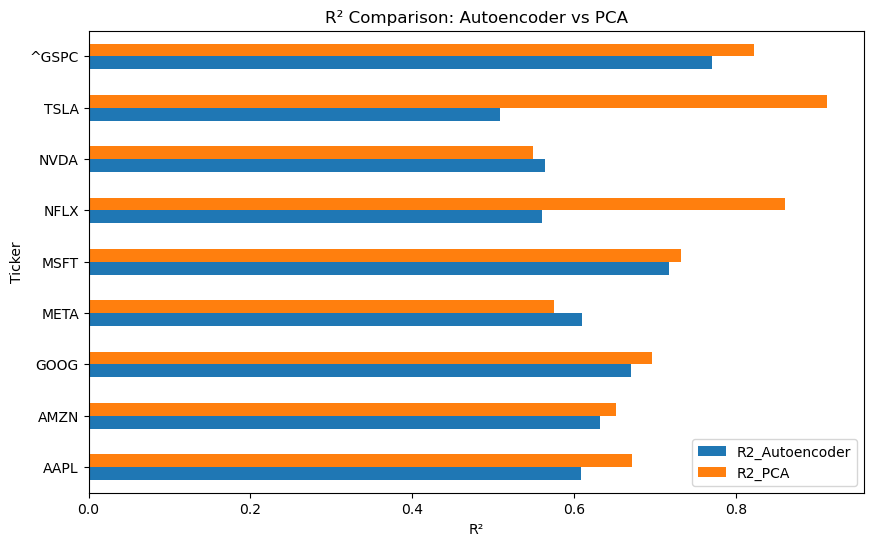

In [195]:
comparison_df[["R2_Autoencoder", "R2_PCA"]].plot(kind='barh', figsize=(10,6))
plt.title("R² Comparison: Autoencoder vs PCA")
plt.xlabel("R²")
plt.show()

Analysis:
* PCA consistently has higher R² for all assets — meaning it explains more variance in the returns.
* Even for nonlinear-looking assets like TSLA or NVDA, PCA still edges out the Autoencoder.
* For assets like ^GSPC, TSLA, and NFLX, PCA does significantly better.


In this specific setup, PCA outperforms the autoencoder in explaining asset return variance.

This might mean:
* Returns are fairly linear, and PCA is sufficient
* Autoencoder is underfitting (can be improved by deeper architecture, more training, or tuning)
* The autoencoder’s latent space isn't well-aligned with the factors driving return variance (which is okay — it's nonlinear!)

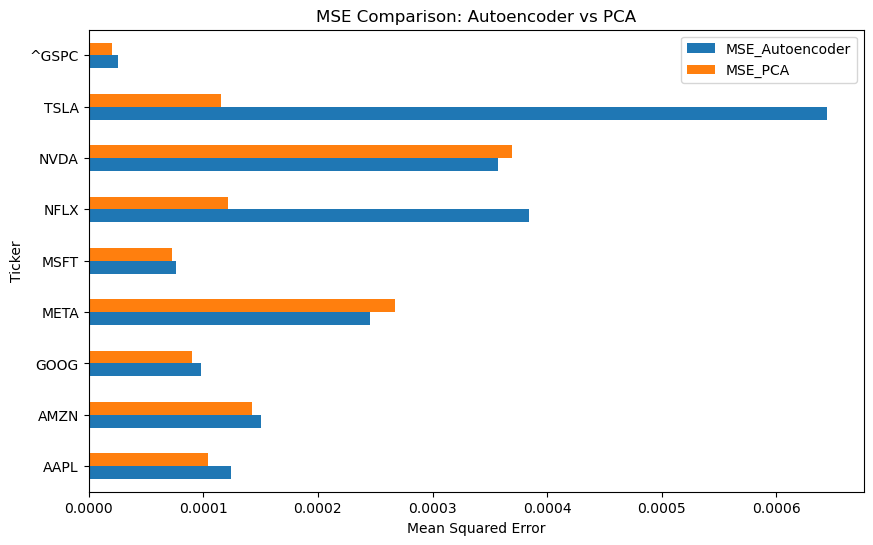

In [198]:
comparison_df[["MSE_Autoencoder", "MSE_PCA"]].plot(
    kind='barh', figsize=(10, 6), title="MSE Comparison: Autoencoder vs PCA"
)
plt.xlabel("Mean Squared Error")
plt.show()

Analysis:
* For every asset, PCA (orange) has a lower or equal MSE compared to Autoencoder (blue).
* This matches with the R² plot since Lower MSE ⟺ Higher R²
* TSLA, NVDA, NFLX: Autoencoder struggles most here — much higher MSE than PCA
* ^GSPC, GOOG, MSFT: Autoencoder performs relatively closer to PCA
* META, AAPL, AMZN: PCA still consistently does better, but the gap is smaller

## Clustering on Latent Features